In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from folium import Map
from folium import Marker

# The Shape data of Districts in Boston
shape = pd.read_csv('../../data/shapefile.csv')

# The Shootings dashboard contains information on shooting incidents where a victim was struck by a bullet, either fatally or non-fatally
shootings=pd.read_csv('../../data/shootings.csv')

#
violence=pd.read_csv('../../data/violence.csv')

# crime incident reports
crime_incident=pd.read_csv('../../data/crime_incident_reports_2022.csv', low_memory=False)

#The Student Discipline Data Report reports the disciplines that public school students in Massachusetts 
# received for the offenses committed, as reported by school districts in the School Safety Discipline Report (SSDR).
disciplines = pd.read_excel('../../data/StudentDisciplineDataReport.xlsx')
licenses = pd.read_excel('../../data/Firearms Licenses Active on 01.01.23.xlsx')

# Individual, de-identified records of firearms transactions by firearms dealers. 
# Includes dates; shop name and location; and make, model, and other information about the firearm sold.
transactions = pd.read_csv('../../data/Firearms Dealer transactions.csv')




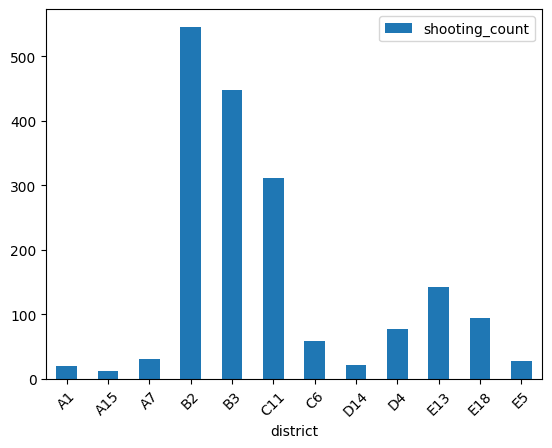

In [7]:
temp = shootings.groupby('district').agg({'district': 'count'}).rename(columns={'district': 'shooting_count'}).reset_index()
temp.plot.bar(x='district', y='shooting_count',rot = 45)
plt.show()

Above is the shooting number in each district

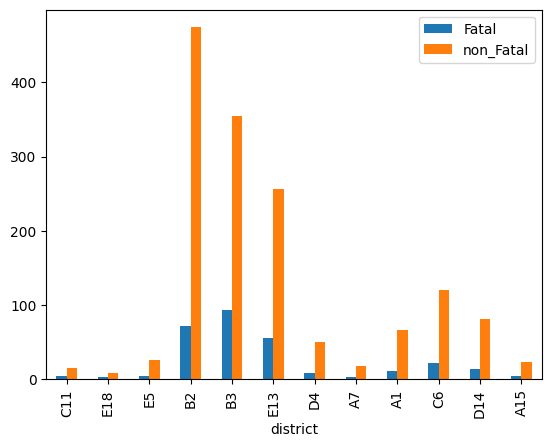

In [8]:
temp = pd.DataFrame()
temp['district'] = shootings['district'].unique()
temp['Fatal']= shootings[shootings['shooting_type_v2'] == 'Fatal'].groupby(['district']).agg({'district': 'count'}).rename(columns={'district': 'x'}).reset_index()['x']
temp['non_Fatal']= shootings[shootings['shooting_type_v2'] == 'Non-Fatal'].groupby(['district']).agg({'district': 'count'}).rename(columns={'district': 'x'}).reset_index()['x']
temp.plot.bar(x='district')
plt.show()

We compare the fatal shooting number and non fatal shooting number in each district. Found that C11, E18, E5, A7, A15 generally has lower shooting cases. We intend to find the different between these districts and the other district with higher shooting number.

In [5]:
# find diff

/var/folders/ct/ytm4tvld3jjc50738s4mm_6w0000gn/T/ipykernel_87035/880258023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[col] = shape[col]/shape[col].sum()


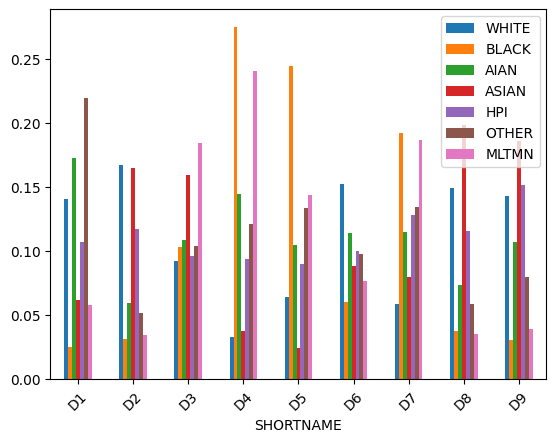

In [9]:
temp = shape[['SHORTNAME','TOTAL','TOTAL18','TOTALNH','WHITE', 'BLACK',
       'AIAN', 'ASIAN', 'HPI', 'OTHER', 'MLTMN']]
for col in temp.columns[1:]:
    temp[col] = shape[col]/shape[col].sum()
#temp.plot.bar(x = 'SHORTNAME', y = [lambda x: x/x.sum()])
temp.plot.bar(x='SHORTNAME',y = temp.columns[4:], rot = 45)
plt.show()

We can see that D4 has way more black people and MLYMN, and have fewest proportion of White. Proportion of Asian is also relatively low.

Non-Fatal    66
Fatal        11
Name: shooting_type_v2, dtype: int64


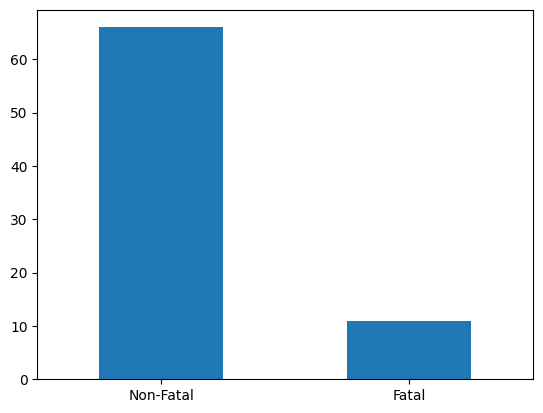

In [10]:
d4shooting=shootings.loc[shootings['district']=='D4',:]

type_stats=d4shooting['shooting_type_v2'].value_counts()
print(type_stats)
type_stats.plot(kind='bar',rot=0)
plt.show()

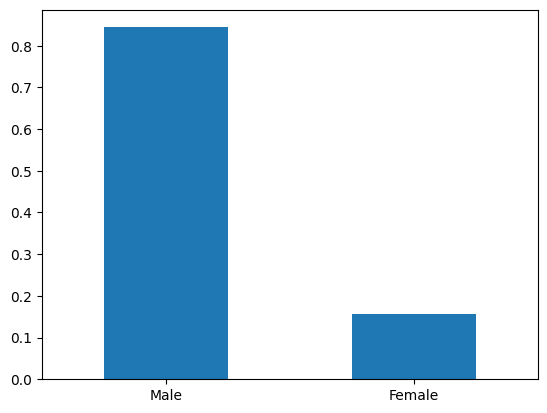

In [11]:
gender=(d4shooting['victim_gender'].value_counts()/d4shooting.shape[0]).plot(kind='bar',rot=0)


Above two images indicate that around 88% of the shooting events are non-Fatal and the ratio of male victim is much higher than the ratio of female victim.

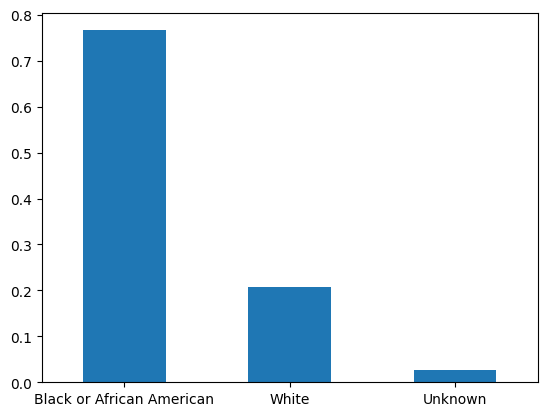

In [12]:
gender=(d4shooting['victim_race'].value_counts()/d4shooting.shape[0]).plot(kind='bar',rot=0)


The ratio of black or african american victim is much higher than the ratio of white victim.

The observation shows that out of the total number of violence incidents, only 6 involved the use of guns, while 1339 incidents did not involve any gunshots.

In [15]:
map_data=violence.groupby('Location',as_index=False).size()
location=map_data.Location.str.replace("(","").str.replace(")","").str.split(",",expand=True)
map_data[['latitude','longitude']]=location
#print(map_data)
map_data.drop('Location',axis=1,inplace=True)
size = map_data.pop('size')
map_data.insert(2,'size',size)

#print(map_data)
base_map = Map(location=[42.33182960914501, -71.0734727352688], zoom_start=12)
HeatMap(map_data).add_to(base_map)
base_map

/var/folders/ct/ytm4tvld3jjc50738s4mm_6w0000gn/T/ipykernel_87035/1709139204.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  location=map_data.Location.str.replace("(","").str.replace(")","").str.split(",",expand=True)


From the heatmap, I observed that the east part of the district 4 has more violence.

                latitude            longitude  size  \
0     42.233341511885946   -71.13368781192425     1   
1      42.23362593785844   -71.13299327865703     1   
2      42.23395999698961   -71.13433994670031     1   
3      42.23396095398864   -71.13228408119066     1   
4      42.23480079104277   -71.13396521652726     3   
...                  ...                  ...   ...   
4216  42.392494278906696   -71.01223082756853     1   
4217   42.39269663200214   -71.00842413382442     2   
4218   42.39327288451406   -71.00793914033349     2   
4219   42.39351800579533    -71.0114050308235     1   
4220   42.39504158023912   -71.01017731687807     3   

                        geometry  
0     POINT (-71.13369 42.23334)  
1     POINT (-71.13299 42.23363)  
2     POINT (-71.13434 42.23396)  
3     POINT (-71.13228 42.23396)  
4     POINT (-71.13397 42.23480)  
...                          ...  
4216  POINT (-71.01223 42.39249)  
4217  POINT (-71.00842 42.39270)  
4218  POINT (-71.00794 4

<AxesSubplot: >

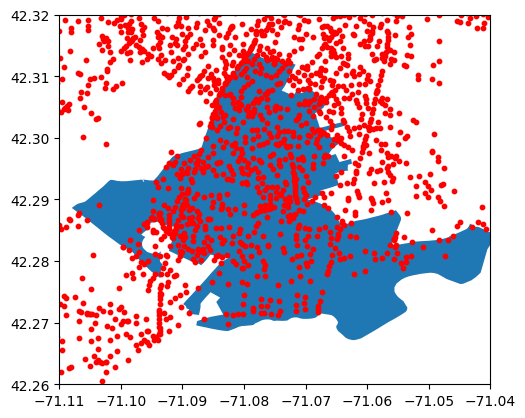

In [16]:
import geopandas as gpd
distrcit_shape = gpd.read_file("../../data/City_Council_Districts_-_Effective_for_the_2023_Municipal_Election.geojson")
# get the district 4 map
d4 = distrcit_shape[distrcit_shape['DISTRICT']==4]
# Convert the dataframe to a geopandas GeoDataFrame
geometry = gpd.points_from_xy(map_data.longitude, map_data.latitude)
locations_gdf = gpd.GeoDataFrame(map_data, geometry=geometry)
print(locations_gdf)
# Plot the map with the locations
ax = d4.plot()
ax.set_xlim(-71.11, -71.04)
ax.set_ylim(42.26, 42.32)
locations_gdf.plot(ax=ax, marker='o', color='red', markersize=10)

The above figure shows that the violence happened the most in the middle part of the D4. We have to filter out the
violence of D4 in the future work.

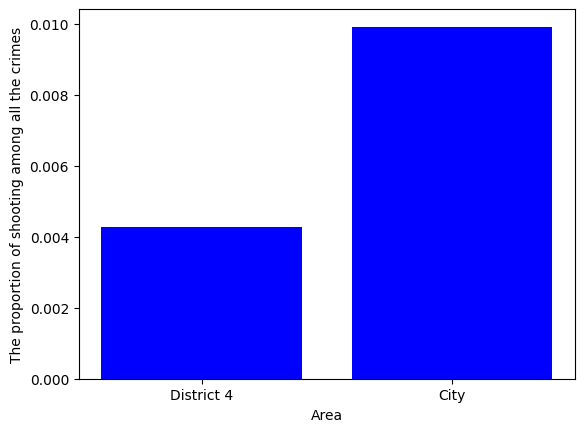

In [17]:
# calculate shooting crime proportion in each area
X = ["District 4","City"]
Y = [crime_incident[(crime_incident['DISTRICT']=='D4') & (crime_incident["SHOOTING"] == 1)].shape[0]/crime_incident[crime_incident['DISTRICT']=='D4'].shape[0],
    crime_incident[crime_incident["SHOOTING"]==1].shape[0]/crime_incident.shape[0]]

plt.bar(X,Y,color='b')
plt.xlabel('Area')
plt.ylabel('The proportion of shooting among all the crimes')
plt.show()
# crime_incident[(crime_incident['DISTRICT']=='D4')]["SHOOTING"].value_counts()

We can tell that District 4 has relatively smaller proportion of shooting crimes compared to the whole city.

In [18]:
crime_incident[crime_incident['DISTRICT']=='D4']["SHOOTING"].value_counts()

0    9551
1      41
Name: SHOOTING, dtype: int64

Similarly, shooting has only 0.42% share of all the crimes in D4.

In [19]:
# heat map for thee whole city crime

map_data=crime_incident.groupby(['Lat', 'Long'], as_index=False).size()

base_map_whole_city = Map(location=[42.33182960914501, -71.0734727352688], zoom_start=12)
HeatMap(map_data).add_to(base_map_whole_city)

#set markers for shooting ones.
crime_incident_shooting = crime_incident[crime_incident["SHOOTING"]==1]

for index, row in crime_incident_shooting.iterrows():
    tooltip = f"{row['OFFENSE_CODE']} ({row['INCIDENT_NUMBER']} incident)"
    if not np.isnan(row['Lat']) and not np.isnan(row['Long']):
        Marker(location=[row['Lat'], row['Long']], tooltip=tooltip).add_to(base_map_whole_city)

base_map_whole_city.save('../../data/crime_map_whole_city.html')
base_map_whole_city

We can see the shooting violence focus mainly on the central part of the city.

In [20]:
crime_d4 = crime_incident[crime_incident["DISTRICT"]=="D4"]

map_data_d4 = crime_d4.groupby(['Lat', 'Long'], as_index=False).size()

base_map_d4 = Map(location=[42.33182960914501, -71.0734727352688], zoom_start=12)
HeatMap(map_data_d4).add_to(base_map_d4)

#set markers for shooting ones.
crime_incident_shooting_d4 = crime_d4[crime_d4["SHOOTING"]==1]

for index, row in crime_incident_shooting_d4.iterrows():
    tooltip = f"{row['OFFENSE_CODE']} ({row['INCIDENT_NUMBER']} incident)"
    if not np.isnan(row['Lat']) and not np.isnan(row['Long']):
        Marker(location=[row['Lat'], row['Long']], tooltip=tooltip).add_to(base_map_d4)

base_map_d4.save('../../data/crime_map_d4.html')
base_map_d4

In terms of D4, shooting crime mainly happened in the southern part.

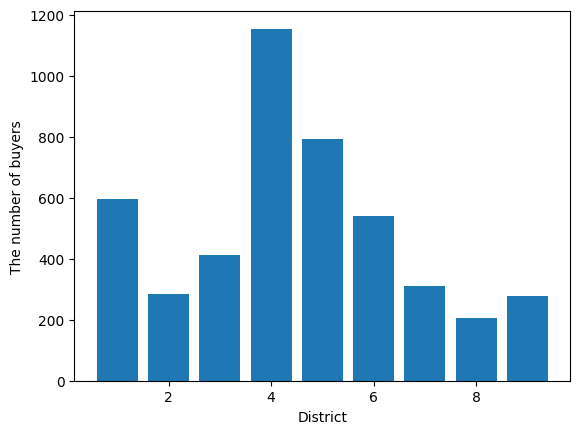

In [21]:
# Zipcode dictionary based on the district map and zipcode map in the "reference"
zipcode_dict = {}
zipcode_dict[1] = [2113.0, 2129.0, 2128.0, 2151.0]
zipcode_dict[2] = [2203.0, 2109.0, 2110.0, 2111.0, 2210.0, 2127.0]
zipcode_dict[3] = [2125.0, 2122.0]
zipcode_dict[4] = [2121.0, 2124.0, 2126.0, 2131.0, 2130.0]
zipcode_dict[5] = [2136.0, 2126.0, 2131.0]
zipcode_dict[6] = [2130.0, 2467.0, 2132.0]
zipcode_dict[7] = [2118.0, 2119.0, 2120.0]
zipcode_dict[8] = [2215.0, 2199.0, 2116.0, 2114.0, 2108.0]
zipcode_dict[9] = [2467.0, 2135.0, 2134.0, 2163.0]

buyer_count = [transactions['BUYER ZIP'].isin(zipcode_dict[x]).sum() for x in zipcode_dict]
plt.bar(range(1,10), buyer_count)
plt.xlabel('District')
plt.ylabel('The number of buyers')
plt.show()


Based on the plot, we found the buyer of guns is highest in District 4 compared to other districts, which can be one of the drivers of violence in District 4.